In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SLAMDataset(Dataset):
    def __init__(self, num_samples=1000, map_size=10):
        self.num_samples = num_samples
        self.map_size = map_size
        self.obstacles = [
            (2, 2, 5, 0.5),
            (7, 3, 1, 4),
            (4, 7, 3, 1)
        ]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = np.random.uniform(0, self.map_size)
        y = np.random.uniform(0, self.map_size)

        distances = []
        for angle in np.linspace(0, 2*np.pi, 8, endpoint=False):
            dist = self.ray_cast(x, y, angle)
            distances.append(dist)

        position = np.array([x/self.map_size, y/self.map_size])
        map_data = self.get_map_patch(x, y)

        return torch.FloatTensor(distances), torch.FloatTensor(position), torch.FloatTensor(map_data)

    def ray_cast(self, x, y, angle):
        max_dist = self.map_size * np.sqrt(2)
        step = 0.1
        dist = 0

        while dist < max_dist:
            dist += step
            px = x + dist * np.cos(angle)
            py = y + dist * np.sin(angle)

            for obs in self.obstacles:
                if (obs[0] <= px <= obs[0]+obs[2]) and (obs[1] <= py <= obs[1]+obs[3]):
                    return dist / max_dist

        return 1.0

    def get_map_patch(self, x, y):
        patch_size = 20
        patch = np.zeros((patch_size, patch_size))

        for i in range(patch_size):
            for j in range(patch_size):
                world_x = x - patch_size//2 + i
                world_y = y - patch_size//2 + j

                for obs in self.obstacles:
                    if (obs[0] <= world_x <= obs[0]+obs[2]) and (obs[1] <= world_y <= obs[1]+obs[3]):
                        patch[i,j] = 1.0
                        break

        return patch

In [ ]:
class SLAMNet(nn.Module):
    def __init__(self):
        super(SLAMNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        self.position_predictor = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Sigmoid()
        )

        self.map_decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 20*20),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        position = self.position_predictor(features)
        map_pred = self.map_decoder(features)
        return position, map_pred.view(-1, 20, 20)

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 50

dataset = SLAMDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = SLAMNet()

position_criterion = nn.MSELoss()
map_criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0.0

    for distances, positions, maps in dataloader:
        optimizer.zero_grad()

        pred_positions, pred_maps = model(distances)

        pos_loss = position_criterion(pred_positions, positions)
        map_loss = map_criterion(pred_maps, maps)
        loss = pos_loss + map_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/50, Loss: 0.6413
Epoch 2/50, Loss: 0.2017
Epoch 3/50, Loss: 0.1649
Epoch 4/50, Loss: 0.1410
Epoch 5/50, Loss: 0.1255
Epoch 6/50, Loss: 0.1214
Epoch 7/50, Loss: 0.1134
Epoch 8/50, Loss: 0.1059
Epoch 9/50, Loss: 0.1018
Epoch 10/50, Loss: 0.0986
Epoch 11/50, Loss: 0.0949
Epoch 12/50, Loss: 0.0905
Epoch 13/50, Loss: 0.0893
Epoch 14/50, Loss: 0.0873
Epoch 15/50, Loss: 0.0850
Epoch 16/50, Loss: 0.0829
Epoch 17/50, Loss: 0.0832
Epoch 18/50, Loss: 0.0796
Epoch 19/50, Loss: 0.0796
Epoch 20/50, Loss: 0.0793
Epoch 21/50, Loss: 0.0795
Epoch 22/50, Loss: 0.0772
Epoch 23/50, Loss: 0.0764
Epoch 24/50, Loss: 0.0776
Epoch 25/50, Loss: 0.0745
Epoch 26/50, Loss: 0.0724
Epoch 27/50, Loss: 0.0730
Epoch 28/50, Loss: 0.0719
Epoch 29/50, Loss: 0.0703
Epoch 30/50, Loss: 0.0719
Epoch 31/50, Loss: 0.0713
Epoch 32/50, Loss: 0.0718
Epoch 33/50, Loss: 0.0712
Epoch 34/50, Loss: 0.0691
Epoch 35/50, Loss: 0.0695
Epoch 36/50, Loss: 0.0683
Epoch 37/50, Loss: 0.0675
Epoch 38/50, Loss: 0.0693
Epoch 39/50, Loss: 0.

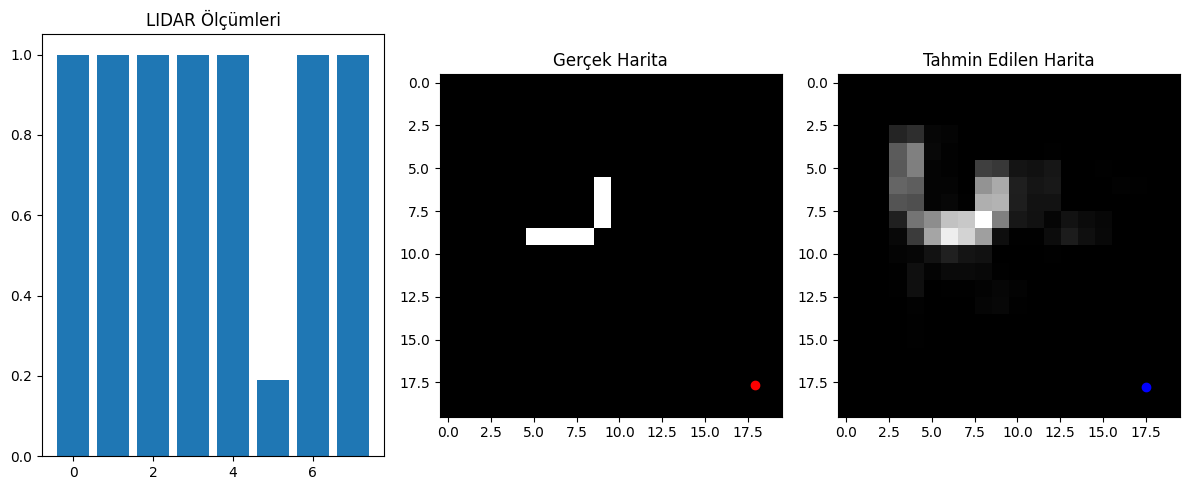

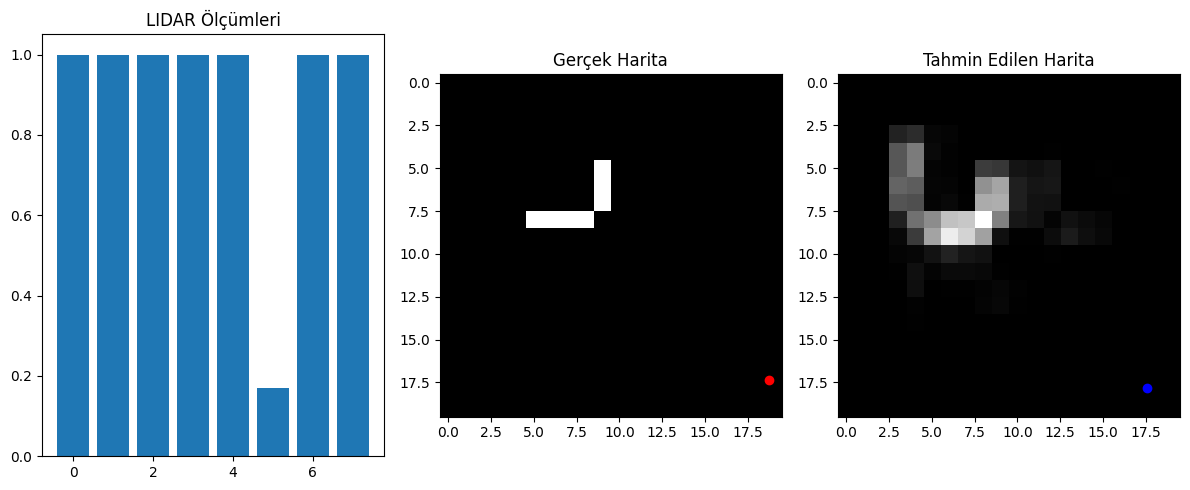

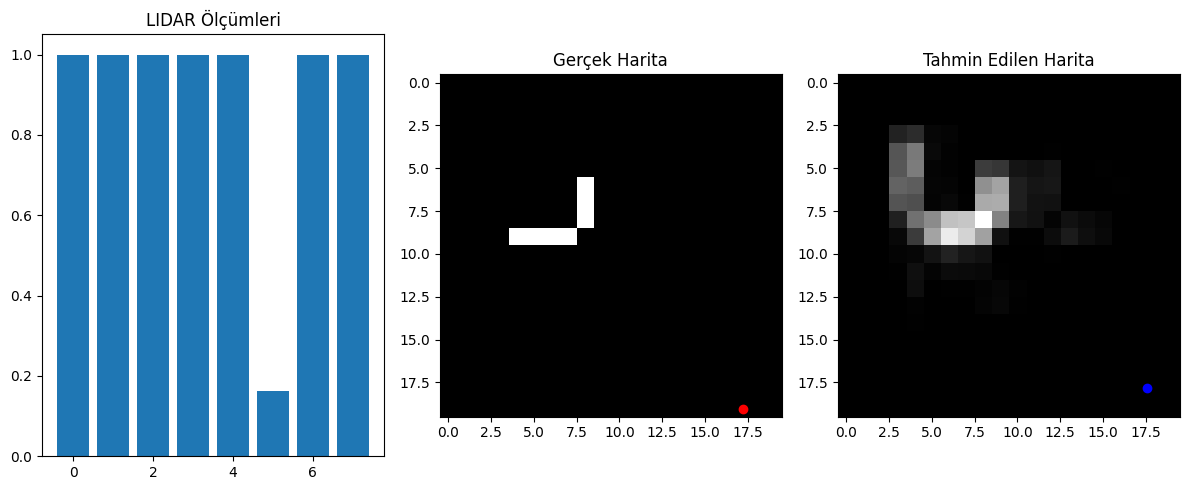

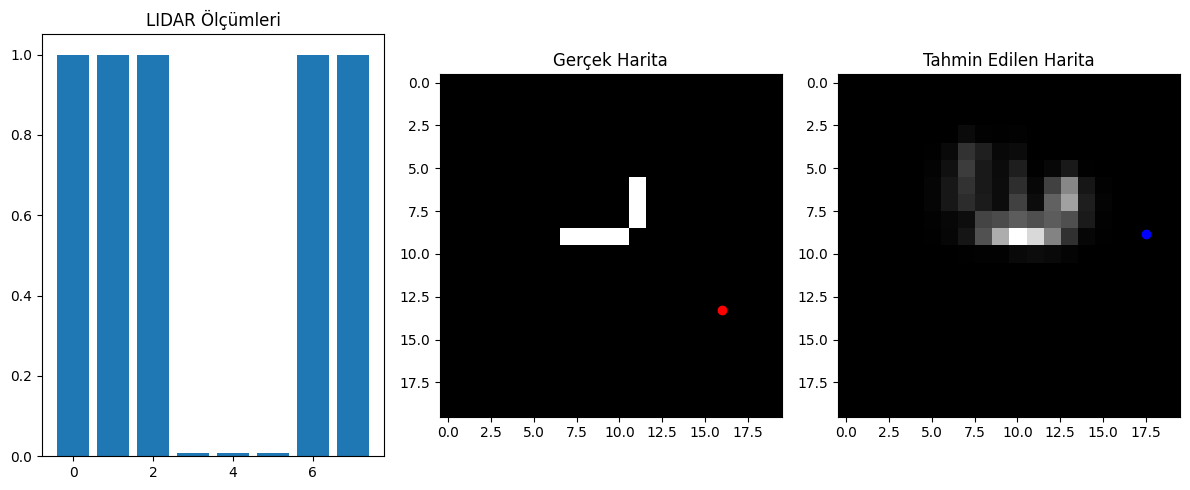

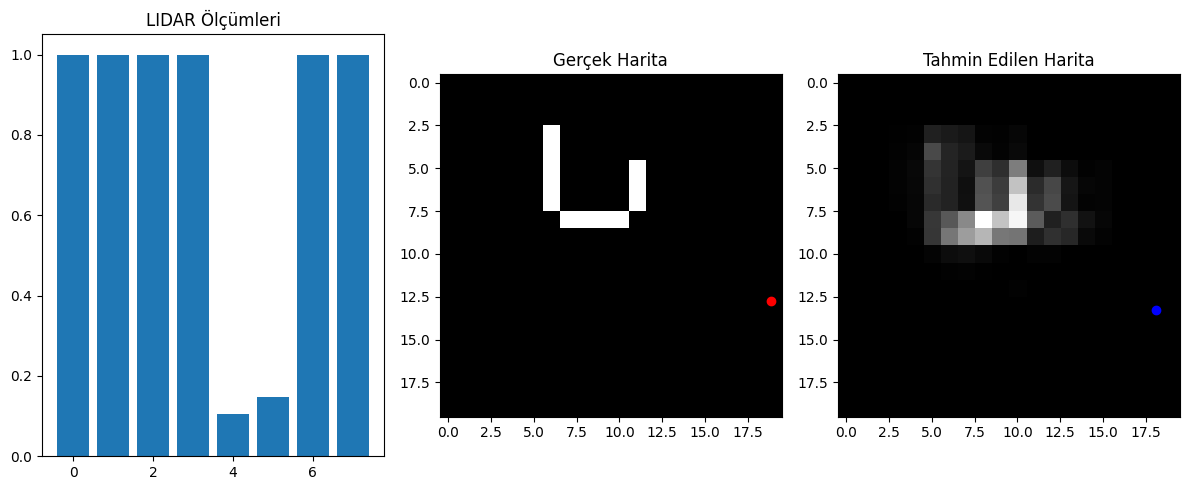

In [ ]:
test_data = SLAMDataset(num_samples=5)

model.eval()
with torch.no_grad():
    for i in range(5):
        distances, true_pos, true_map = test_data[i]
        pred_pos, pred_map = model(distances.unsqueeze(0))

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.title("LIDAR Ölçümleri")
        plt.bar(np.arange(8), distances.numpy())

        plt.subplot(1, 3, 2)
        plt.title("Gerçek Harita")
        plt.imshow(true_map.numpy(), cmap='gray')
        plt.scatter(true_pos[0]*20, true_pos[1]*20, c='red', label='Gerçek Konum')

        plt.subplot(1, 3, 3)
        plt.title("Tahmin Edilen Harita")
        plt.imshow(pred_map.squeeze().numpy(), cmap='gray')
        plt.scatter(pred_pos[0,0]*20, pred_pos[0,1]*20, c='blue', label='Tahmini Konum')

        plt.tight_layout()
        plt.show()